In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
def accuracy_fn(preds, labels):
    """
    Computes the accuracy between predictions and true labels.

    Args:
        preds (torch.Tensor): Model outputs (logits or probabilities).
        labels (torch.Tensor): True class labels.

    Returns:
        float: Accuracy as a percentage.
    """
    # If preds are raw scores (logits), get predicted class by taking argmax
    preds = torch.argmax(preds, dim=1)

    correct = (preds == labels).sum().item()
    total = labels.size(0)

    return 100 * correct / total



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#Train data
training_data = datasets.MNIST(
    root = "/content" ,
    train=True ,
    download=True ,
    transform=ToTensor(),
    target_transform=None
)

#Test Data
test_data = datasets.MNIST(
    root="/content",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.24MB/s]


In [5]:
type(training_data)

torchvision.datasets.mnist.MNIST

In [6]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
image , label = training_data[1]

In [9]:
image.shape , label

(torch.Size([1, 28, 28]), 0)

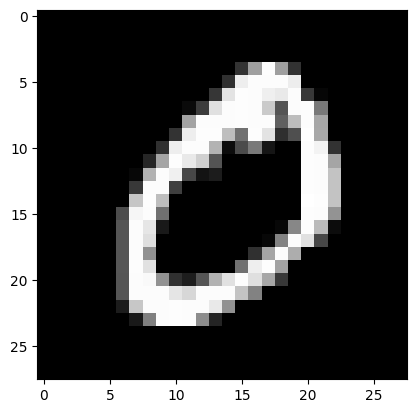

In [10]:
plt.imshow(image.squeeze() , cmap= "gray")

In [11]:
train_data_loader=DataLoader(dataset=training_data,
                            batch_size=64,
                             shuffle=True
                             )

test_data_loader=DataLoader(dataset=test_data,
                            batch_size=64,
                            shuffle=False)

In [12]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [13]:
train_data_loader.batch_size , len(train_data_loader)

(64, 938)

In [14]:
test_data_loader.batch_size , len(test_data_loader)

(64, 157)

In [89]:
torch.manual_seed(42)
class Model(nn.Module):
  def __init__(self,input_size,hidden_units,output_size):
    super().__init__()
    self.cnn_block1= nn.Sequential(
        nn.Conv2d( in_channels=1 ,
                  out_channels=10,
                  kernel_size=3,
                  stride=1,
                  padding=1
                  ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=10,
            out_channels=10,
            kernel_size=3,
            stride=1,
            padding=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.cnn_block2= nn.Sequential(
      nn.Conv2d( in_channels=10,
                out_channels=10,
                kernel_size=3,
                stride=1,
                padding=1
                ),
      nn.ReLU(),
      nn.Conv2d(
          in_channels=10,
          out_channels=10,
          kernel_size=3,
          stride=1,
          padding=1,
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.layers=nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size,hidden_units),
        # nn.ReLU(),
        nn.Linear(hidden_units,output_size),
        # nn.ReLU(),
    )
  def forward(self,X):
    y= self.cnn_block1(X)
    y=self.cnn_block2(y)
    # y=self.cnn_block2(y)
    # print(y.shape)
    y=self.layers(y)
    return y

In [90]:
model=Model(490,30,len(training_data.classes))
model.to(device)

Model(
  (cnn_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [91]:
lossfn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.01,)

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
EPOCH=10
train_loss_values=[]
test_loss_values=[]
for epoch in tqdm(range(EPOCH)):

  train_loss=0
  for batch , (X,y) in enumerate(train_data_loader):
    X=X.to(device)
    y=y.to(device)
    y_pred=model(X)
    loss=lossfn(y_pred,y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(train_data_loader)
  train_loss_values.append(train_loss)


  model.eval()
  test_loss=0
  test_accuracy = 0
  with  torch.inference_mode():
    for X_test,y_test in test_data_loader:
      X_test=X_test.to(device)
      y_test=y_test.to(device)
      y_pred_test=model(X_test)
      test_accuracy+= accuracy_fn(y_pred_test, y_test)
      test_loss+=lossfn(y_pred_test,y_test)


    test_accuracy/=len(test_data_loader)
    test_loss/= len(test_data_loader)
    test_loss_values.append(test_loss)

print(f"test loss for each epoch = {test_loss_values}")
print(f"test Accuracy={test_accuracy}")
print(train_loss_values)

  0%|          | 0/10 [00:00<?, ?it/s]

test loss for each epoch = [tensor(0.0937, device='cuda:0'), tensor(0.0601, device='cuda:0'), tensor(0.0590, device='cuda:0'), tensor(0.0654, device='cuda:0'), tensor(0.0788, device='cuda:0'), tensor(0.0576, device='cuda:0'), tensor(0.0589, device='cuda:0'), tensor(0.0953, device='cuda:0'), tensor(0.0667, device='cuda:0'), tensor(0.0508, device='cuda:0')]
test Accuracy=98.48726114649682
[tensor(0.1519, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0827, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0795, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0749, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0723, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0696, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0718, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0654, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0661, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.0672, device='cuda:0', grad_fn=<DivBackward0>)]
